# Calculating Beta Diversity in Python

In contrast to alpha diversity, beta diversity is fundamentally comparative. It is usually expressed as a *distance*, with higher distances between two communities representing greater biological differences in their communities. 

## In this section
    - Qualitative vs. Quantitative Beta diversity metrics
    - Loading microbial feature tables in Tidy format
    - Using nested `for` loops to iterate over pairs of samples
    - Calculating Jaccard distances 
    

## Prerequisites

- Familiarity with basic python (lists, dicts, if statements, functions, for loops)
- Familiarity with microbiomes and basic perspectives on their analysis (e.g. key species, alpha diversity, beta-diversity, etc)


## Table of Content
* [In this section](#In-this-section)
* [Prerequisites](#Prerequisites)
* [Main Text](#Main-text)
* [Subheading](#Subheading)
* [Subheading 2](#Subheading-2)

## Flavors of Beta Diversity:  Qualitative vs. Quantitative, Phylogenetic vs. Non-Phylogenetic

Because there are many ways to conceptualize how one should mesure how different ecological communities are, Beta diversity can be calculated in different ways. Whatever method or methods one picks, it's important to understand what patterns will influence your beta-diversity values, because this will in turn influence the clusters or other patterns you see among samples, and ultimately your biological interpretation.

The simplest measures of beta diversity simply conceive of it as a measure of how many of the same species are present or absent between two communities, whereas more complex measures of beta diversity might incorporate the abundances of individuals within those species, as well as the relatedness of the species.

Before we dive into code implementing beta-diversity metrics, it's important that we understand what types of conclusions they would reach on *very simple* examples that we can understand inuitively. This is also an opportunity to break down some equations for beta-diversity measures and show the simple (sometimes overly simple!) reasoning they represent. 

We will not attempt to exhaustively catalogue beta-diversity distance measures, but will mention some commonly referenced methods.

### Jaccard distance 

The Jaccard distance is used in several fields. In ecology, the Jaccard for two communities considers species as either absent (if never observed in that community) or present (if observed once or more in a community). Thus, this distance metric can be applied to a table that has only presence/absence data (usually represeted using 1 for presence and 0 for absence). If counts are available, they won't influence the result.

Here is the intuitive equation for the Jaccard distance:  J = 1 - (shared_species/total_species)

**Stop and think**. Consider two communities with perfectly overlapping species. What Jaccard distance would you expect based on the above equation? Now consider two communities with totally different, non-overlapping sets of species. What Jaccard distance would you expect there?


# Implementing a Comparison of Microbiome Beta Diversity

## Check data availability

First let's download a data file to work with. You can find scenario_1_otus_pandas.tsv <a href="feature_table_r16_selected_microbes.txt"> here </a> Download it into the same folder as your jupyter notebook, then let's confirm that we've got it. If we have the feature table we are going to analyze in our current working directory, we should be able to see the file `feature_table_r16_selected_microbes.txt`when we run `listdir()`.

If you have any trouble, you can make your own Excel or Google sheets file matching the data shown below, then download that in tab-delimited format into your current working directory. 

We could simply use listdir like in the past to confirm files are present. In this case, we have a couple files to check. As the number of input files increases, it can be worth consolidating checks for whether they are present into a function.

Note that in real applications this usually isn't for you (you can just check the files are there), but rather to prevent frustration on the part of folks who are trying to reproduce your results. If files are missing we want to alert them up front, rather than having them get a potentially confusing error later in the process.





In [112]:
from os.path import exists
from os import listdir

required_files = ["./herbivore_feature_table_r16_selected_microbes.txt","individual_mapping_r3.txt"]


def check_file_availability(required_files,expected_data_folder="./"):
    """Print status of required files"""
    missing_files = []
    for f in required_files:
        if not exists(f):
            print(f"{f}......Missing from {expected_data_folder}")
            missing_files.append(f)
        else:
            print(f"{f}......OK")
    
    if missing_files:
        print(f"Check that each missing file exists, is specified by its full path and is in the expected folder before proceeding")
        print(f"\nFiles that *are* in your data folder {expected_data_folder} are:\n","\n".join(listdir(expected_data_folder)))
    return missing_files

missing_files = check_file_availability(required_files)


./herbivore_feature_table_r16_selected_microbes.txt......OK
individual_mapping_r3.txt......OK


## Load feature table data

Let's begin by importing `pandas`, loading our feature table data as a `pandas` `DataFrame` object, and then setting the `OTU_ID` column — which uniquely identifies each type of microbe — to be our index

In [113]:
import pandas as pd

feature_table = pd.read_csv("herbivore_feature_table_r16_selected_microbes.txt", sep = "\t",skiprows = 1)
feature_table = feature_table.set_index("#OTU ID")
feature_table

,1,2,3,4,5,6,7,9,10,11,...,2NC2_ST3,2NU1_PA8,3NC2_SS2,3NU1_SS3,4CU1_SS1,4NU1_SS2,83,20,75,1NU1_SS2
#OTU ID,,,,,,,,,,,,,,,,,,,,,
k__Bacteria;p__Cyanobacteria;c__Synechococcophycideae;o__Synechococcales,0.155,0.195667,0.116000,0.093667,0.142000,0.2440,0.203833,0.182,0.122286,0.165714,...,0.202,0.311,0.087,0.048,0.377,0.142,0.112,0.231750,0.046,0.392
k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales,0.116,0.055333,0.087667,0.118333,0.118333,0.1082,0.058667,0.117,0.064286,0.068286,...,0.025,0.048,0.073,0.071,0.083,0.170,0.066,0.058500,0.044,0.061
k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales,0.005,0.007667,0.022000,0.013667,0.006333,0.0058,0.006500,0.007,0.027143,0.016571,...,0.000,0.014,0.016,0.015,0.002,0.024,0.016,0.011750,0.004,0.004
k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales,0.011,0.011667,0.021000,0.011667,0.009667,0.0302,0.036333,0.031,0.020571,0.029000,...,0.037,0.039,0.010,0.005,0.037,0.003,0.026,0.016750,0.000,0.057
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales,0.019,0.050000,0.083333,0.099667,0.045667,0.0368,0.075667,0.060,0.070714,0.076857,...,0.027,0.065,0.107,0.099,0.034,0.070,0.112,0.065250,0.018,0.019
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales,0.006,0.025667,0.011000,0.001000,0.010333,0.0242,0.031667,0.001,0.008714,0.008857,...,0.009,0.000,0.000,0.002,0.000,0.002,0.000,0.002000,0.012,0.000
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales,0.006,0.010333,0.025667,0.021667,0.008333,0.0092,0.011000,0.030,0.040571,0.025143,...,0.001,0.013,0.031,0.061,0.002,0.026,0.023,0.015250,0.003,0.003
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales,0.016,0.023000,0.026000,0.065333,0.053667,0.1154,0.033333,0.010,0.011000,0.022000,...,0.021,0.018,0.029,0.017,0.007,0.069,0.057,0.089125,0.022,0.010
k__Bacteria;p__Acidobacteria,0.001,0.002333,0.004667,0.002667,0.001000,0.0008,0.001333,0.003,0.007571,0.005571,...,0.006,0.000,0.004,0.005,0.000,0.012,0.005,0.003125,0.000,0.000


## Calculating Beta Diversity in Python

Beta diversity is fundamentally comparative: it describes how different  a given pair of samples, plots, or communities are from one another. Thus, unlike alpha diversity, beta diversity can only be calculated on pairs of samples. 

Nonetheless, much of the process is similar to what we did in the previous chapter on alpha diversity. Just like we started analyzing our alpha diversity data by writing a function to calculate an alpha diversity metric given a single sample, for beta diversity we want to start by writing code to calculate one measure of beta diversity distance given a pair of samples. Once that code is tested and wrapped into a function, we can interate over pairs of samples to calculate all possible beta-diversity distances for our table.

### Calculating the Jaccard distance given a pair of samples

As we saw above, the Jaccard measure of similarity reflects the fraction of species present (abundance > 0) in a pair of samples, as a proportion of all species present in *either* sample. This is converted to a beta diversity distance by subtracting from  1. Thus, if 25% of species are shared, then 75% are different and Jaccard is 0.75.

We need to be aware that some species may be in our table, but not present in either sample, since each type of microbe present in any part of the dataset will get it's own row. So we are interested in rows with counts above 0.





In [114]:
def jaccard_distance(s1,s2):
    """Return Jaccard distance given two lists of counts
    
    s1 -- a list of counts  for each taxon in sample1
    s2 -- a list of counts for each taxon in sample2
    
    Jaccard distance = 1 - shared_species/total_species
    
    Note that the two lists of counts must already be identical in length, and sorted in the same order.
    At least one list must also have a non-zero value (i.e. one species must be present somewhere)
    """
    if len(s1) != len(s2):
        raise ValueError("Lists must be the same length to calculate the Jaccard index!")
    
    #Strategy: iterate over each position in both lists
    #then check if species is present in one or both
    
    shared = 0
    total = 0
    
    
    for i,abundance in enumerate(range(len(s1))):
        if s1[i] > 0.0 or s2[i] > 0.0:
            total += 1
        
        if s1[i] > 0.0 and s2[i] > 0.0:
            shared += 1
            
    #Before we try to do the calculation,
    #raise an informative error if S1 and S2 are both all zeros
    
    #This avoids a harder to interpret ZeroDivisionError 
    #when calculating the result if the total is 0.
    
    if total == 0:
        raise ValueError("Can't calculate Jaccard distance: no species are present in either sample!")
    
    
    result =  1 - (shared/total)
    return result

### Test our Jaccard distance function

As always, we need to test our function on example data before we can use it for research. Three easy tests to calculate by hand would be:

- if samples share no species, the distance should be 1.0
- if samples share all species, the distance should be 0.0
- if samples share half of their species, the distance should be 0.5
- if both samples are empty, the distance should be undefined, and we would raise an error

#### Test that non-overlapping samples have a Jaccard distance of 1

If two samples have none of the same species, they should have a distance of 1.

In [115]:
s1 = [1,0,0]
s2 = [0,0,1]

expected = 1.0
observed = jaccard_distance(s1,s2)
test_result = observed == expected
print(f"Jaccard distance finds distance 1 for non-overlapping samples..........{test_result}")

Jaccard distance finds distance 1 for non-overlapping samples..........True


#### Test that perfectly overlapping samples have a Jaccard distance of 0

If two samples have all the same species, they should have a distance of 0

In [116]:
s1 = [1,0,1]
s2 = [1,0,1]

expected = 0.0
observed = jaccard_distance(s1,s2)
test_result = observed == expected
print(f"Jaccard distance finds distance 1 for non-overlapping samples..........{test_result}")

Jaccard distance finds distance 1 for non-overlapping samples..........True


#### Test that half overlapping samples have a Jaccard distance of 0.5

In [117]:
s1 = [1,0,0,1]
s2 = [1,0,0,0]

expected = 0.5
observed = jaccard_distance(s1,s2)
test_result = observed == expected
print(f"Jaccard distance finds distance 0.5 for half overlapping samples..........{test_result}")

Jaccard distance finds distance 0.5 for half overlapping samples..........True


#### Testing for how our function handles invalid input

To really test our function, we'd want to also figure out how it should behave in some funky cases. For example, what if no species are present in *either* sample? This is a weird case, but could show up if we originally had a feature table and it was filtered in some way. In that case we could either define the distance between two empty samples as 0 (and make that very clear in documentation), or we could leave it undefined and raise an appropriate error. 

Let's say we were doing the latter. How could we test if an error is raised? If we're working with a unit testing package (what we'd really do for a larger project) there will be an option to test if we're raising the right type of error. For right now, let's show a simple version of that using a `try` - `except` block.

In [118]:
s1 = [0,0,0,0]
s2 = [0,0,0,0]

error_raised = False
try:
    observed = jaccard_distance(s1,s2)
except ValueError:
    error_raised = True

test_result = error_raised
print(f"Jaccard distance raises a ValueError for two empty samples..........{test_result}")

Jaccard distance raises a ValueError for two empty samples..........True


Whew! That was a decent amount of coming up with tests. However, the more we write the more confident we'll be in our code. In this case, we only caught that we needed special handling of two empty samples when thinking about cases that could produce weird or incorrect behavior.

Of course, we could have handled this differently, e.g. by setting two empty samples to have a Jaccard distance of 0. The most important thing is that we have some reasoning for why we are doing things a particular way, we have tested that the function actually does them that way, and that handling is fairly clear from the documentation.


**Try it yourself**: write at least one additional informal test of the jaccard_distance function.

## Looping over pairs of samples to calculate Beta diversity for a table 

Because beta diversity is comparative, we need to compare each *pair* of columns to one another. This can be done with a nested `for` loop: an outer loop that gives us each 'sample1' one by one, and an inner loop that gives us eah 'sample2' to compare it to. Since these functions are pretty similar, let's modify our alpha diversity code.

*If this seems intimidating, a great first step is to write a function that just prints out the names of all pairs of samples*. So if the samples are 1,2,3, try writing a double or nested for loop that prints out "1_vs_1" then "1_vs_2" then "1_vs_3" then "2_vs_1" ...etc until you get to 3_vs_3. I would almost always do this as the first step before doing anything fancier.

This first step can reuse code for iterating over columns of a dataframe from the alpha diversity chapter. Having written this code already, we have a leg up on writing some nested for loops that get us pairs of samples, since we can reuse our `iterate_over_columns` function. This illustrates the advantages of writing moduler code: it costs a little bit of time up front, but often saves a ton of time down the line by letting you reuse reasoning.

If we can convince ourselves that we can find pairs of samples and their data, then we just have to feed them into our Jaccard distance metric to get beta diversities. From there, it's a matter of storing & exporting the results. Let's take it step by step.

### Iterating over pairs of samples in a dataframe

Let's start by writing (or reusing) an `iterate_over_columns` function like we used in the last chapter. For now we'll hook it up to a beta diversity function that just prints out what samples will be compared, without actually doing any math. Once we've confirmed we can get each pair of samples we want to compare we'll be much closer to actually calculating beta diversity.

In [119]:
def iterate_over_columns(df):
    """Yield columns of a dataframe one by one as lists
    
    df -- a pandas DataFrame
    """

    all_cols = list(df.columns)

    for col in all_cols: 
        column_data = df.loc[:,col]
        column_data = list(column_data)

        yield col,column_data
        
def calc_beta_diversity(df,metric = "dummy"):
    """Return alpha diversity for all samples in a table as a pandas dataframe
    
    metric -- a string specifying what alpha diversity metric to use
    

    """

    for sample1_id,sample1_data in iterate_over_columns(feature_table):
        for sample2_id,sample2_data in iterate_over_columns(feature_table):
            print(f"Comparing {sample1_id} vs {sample2_id}")
            print(f"S1 data: {sample1_data}")
            print(f"S2 data: {sample2_data}")
            
calc_beta_diversity(feature_table)

Comparing 1 vs 1
S1 data: [0.155, 0.116, 0.005, 0.011, 0.019, 0.006, 0.006, 0.016, 0.001, 0.018, 0.07, 0.176, 0.004, 0.6]
S2 data: [0.155, 0.116, 0.005, 0.011, 0.019, 0.006, 0.006, 0.016, 0.001, 0.018, 0.07, 0.176, 0.004, 0.6]
Comparing 1 vs 2
S1 data: [0.155, 0.116, 0.005, 0.011, 0.019, 0.006, 0.006, 0.016, 0.001, 0.018, 0.07, 0.176, 0.004, 0.6]
S2 data: [0.195666667, 0.055333333, 0.007666667, 0.011666667, 0.05, 0.025666667, 0.010333333, 0.023, 0.002333333, 0.044, 0.16, 0.233333333, 0.055333333, 0.437]
Comparing 1 vs 3
S1 data: [0.155, 0.116, 0.005, 0.011, 0.019, 0.006, 0.006, 0.016, 0.001, 0.018, 0.07, 0.176, 0.004, 0.6]
S2 data: [0.116, 0.087666667, 0.022, 0.021, 0.083333333, 0.011, 0.025666667, 0.026, 0.004666667, 0.034333333, 0.124666667, 0.154333333, 0.006, 0.494333333]
Comparing 1 vs 4
S1 data: [0.155, 0.116, 0.005, 0.011, 0.019, 0.006, 0.006, 0.016, 0.001, 0.018, 0.07, 0.176, 0.004, 0.6]
S2 data: [0.093666667, 0.118333333, 0.013666667, 0.011666667, 0.099666667, 0.001, 0.0216666

S1 data: [0.1208, 0.0653, 0.0125, 0.0519, 0.0668, 0.0035, 0.0153, 0.0516, 0.0028, 0.0374, 0.1264, 0.1446, 0.0174, 0.4538]
S2 data: [0.201, 0.0756, 0.0046, 0.0474, 0.0666, 0.004, 0.0156, 0.0282, 0.008, 0.0494, 0.201, 0.2164, 0.0032, 0.4092]
Comparing 23 vs 29
S1 data: [0.1208, 0.0653, 0.0125, 0.0519, 0.0668, 0.0035, 0.0153, 0.0516, 0.0028, 0.0374, 0.1264, 0.1446, 0.0174, 0.4538]
S2 data: [0.1335, 0.0749, 0.0063, 0.0207, 0.0819, 0.0075, 0.0138, 0.0358, 0.0038, 0.0373, 0.1194, 0.2118, 0.0266, 0.4528]
Comparing 23 vs 30
S1 data: [0.1208, 0.0653, 0.0125, 0.0519, 0.0668, 0.0035, 0.0153, 0.0516, 0.0028, 0.0374, 0.1264, 0.1446, 0.0174, 0.4538]
S2 data: [0.145, 0.172, 0.006, 0.015, 0.168, 0.001, 0.006, 0.011, 0.004, 0.03, 0.136, 0.194, 0.002, 0.519]
Comparing 23 vs 31
S1 data: [0.1208, 0.0653, 0.0125, 0.0519, 0.0668, 0.0035, 0.0153, 0.0516, 0.0028, 0.0374, 0.1264, 0.1446, 0.0174, 0.4538]
S2 data: [0.22225, 0.064625, 0.01, 0.089, 0.032875, 0.0085, 0.015125, 0.02225, 0.001625, 0.0335, 0.133375, 0

Comparing 37 vs 3NC2_SS2
S1 data: [0.119, 0.11525, 0.006, 0.01575, 0.058, 0.028, 0.00475, 0.241, 0.00075, 0.0195, 0.057, 0.12425, 0.0055, 0.7465]
S2 data: [0.087, 0.073, 0.016, 0.01, 0.107, 0.0, 0.031, 0.029, 0.004, 0.016, 0.156, 0.132, 0.001, 0.484]
Comparing 37 vs 3NU1_SS3
S1 data: [0.119, 0.11525, 0.006, 0.01575, 0.058, 0.028, 0.00475, 0.241, 0.00075, 0.0195, 0.057, 0.12425, 0.0055, 0.7465]
S2 data: [0.048, 0.071, 0.015, 0.005, 0.099, 0.002, 0.061, 0.017, 0.005, 0.022, 0.141, 0.12, 0.002, 0.564]
Comparing 37 vs 4CU1_SS1
S1 data: [0.119, 0.11525, 0.006, 0.01575, 0.058, 0.028, 0.00475, 0.241, 0.00075, 0.0195, 0.057, 0.12425, 0.0055, 0.7465]
S2 data: [0.377, 0.083, 0.002, 0.037, 0.034, 0.0, 0.002, 0.007, 0.0, 0.04, 0.129, 0.387, 0.002, 0.386]
Comparing 37 vs 4NU1_SS2
S1 data: [0.119, 0.11525, 0.006, 0.01575, 0.058, 0.028, 0.00475, 0.241, 0.00075, 0.0195, 0.057, 0.12425, 0.0055, 0.7465]
S2 data: [0.142, 0.17, 0.024, 0.003, 0.07, 0.002, 0.026, 0.069, 0.012, 0.034, 0.073, 0.201, 0.001, 0.

Comparing 41 vs 13
S1 data: [0.208166667, 0.0745, 0.0055, 0.028, 0.055, 0.02, 0.009666667, 0.013833333, 0.002166667, 0.045666667, 0.152166667, 0.243333333, 0.022333333, 0.420333333]
S2 data: [0.112333333, 0.072333333, 0.007833333, 0.014833333, 0.086166667, 0.001333333, 0.024333333, 0.081833333, 0.0035, 0.022833333, 0.116166667, 0.135, 0.036666667, 0.526333333]
Comparing 41 vs 15
S1 data: [0.208166667, 0.0745, 0.0055, 0.028, 0.055, 0.02, 0.009666667, 0.013833333, 0.002166667, 0.045666667, 0.152166667, 0.243333333, 0.022333333, 0.420333333]
S2 data: [0.14925, 0.1055, 0.0055, 0.0125, 0.09025, 0.00225, 0.00975, 0.06625, 0.00175, 0.021, 0.17975, 0.16175, 0.0155, 0.471]
Comparing 41 vs 16
S1 data: [0.208166667, 0.0745, 0.0055, 0.028, 0.055, 0.02, 0.009666667, 0.013833333, 0.002166667, 0.045666667, 0.152166667, 0.243333333, 0.022333333, 0.420333333]
S2 data: [0.090285714, 0.104285714, 0.009428571, 0.012857143, 0.061285714, 0.007857143, 0.025714286, 0.03, 0.004142857, 0.029, 0.144285714, 0.134

Comparing 2CC2_SS3 vs 24
S1 data: [0.169, 0.058, 0.018, 0.024, 0.083, 0.0, 0.033, 0.017, 0.007, 0.025, 0.115, 0.183, 0.0, 0.507]
S2 data: [0.265333333, 0.047666667, 0.002333333, 0.051, 0.027666667, 0.018666667, 0.004666667, 0.005666667, 0.0, 0.062333333, 0.149666667, 0.269333333, 0.065666667, 0.354]
Comparing 2CC2_SS3 vs 25
S1 data: [0.169, 0.058, 0.018, 0.024, 0.083, 0.0, 0.033, 0.017, 0.007, 0.025, 0.115, 0.183, 0.0, 0.507]
S2 data: [0.1022, 0.0822, 0.0082, 0.0448, 0.0754, 0.0104, 0.013, 0.0356, 0.0024, 0.0268, 0.125, 0.1516, 0.0158, 0.4772]
Comparing 2CC2_SS3 vs 26
S1 data: [0.169, 0.058, 0.018, 0.024, 0.083, 0.0, 0.033, 0.017, 0.007, 0.025, 0.115, 0.183, 0.0, 0.507]
S2 data: [0.321, 0.081, 0.007, 0.012, 0.074, 0.0, 0.012, 0.018, 0.002, 0.045, 0.113, 0.335, 0.01, 0.367]
Comparing 2CC2_SS3 vs 27
S1 data: [0.169, 0.058, 0.018, 0.024, 0.083, 0.0, 0.033, 0.017, 0.007, 0.025, 0.115, 0.183, 0.0, 0.507]
S2 data: [0.011, 0.288, 0.0, 0.002, 0.023, 0.0, 0.016, 0.0, 0.004, 0.008, 0.111, 0.013,

**Try it yourself**: Try running the code above (you need to run the cell that defines the iterate_over_columns function if you haven't yet this session). Can you verify that you are getting all pairs of samples? 

Now that we have confirmed we're getting data for all pairs of samples (including self vs. self comparisons) our next step is to incorporate our Jaccard distance metric. Let's try it, noting that many beta-diversities in this particular table will be 0 since they have all the same taxa present.

In [120]:
def calc_beta_diversity(df):
    """Return alpha diversity for all samples in a table as a pandas dataframe
    
   df -- a pandas dataframe with samples on columns and species on rows
    """

    for sample1_id,sample1_data in iterate_over_columns(feature_table):
        for sample2_id,sample2_data in iterate_over_columns(feature_table):
            print(f"Comparing {sample1_id} vs {sample2_id}")
            beta_diversity = jaccard_distance(sample1_data,sample2_data)
            print(f"Beta diversity:",beta_diversity)
            
calc_beta_diversity(feature_table)

Comparing 1 vs 1
Beta diversity: 0.0
Comparing 1 vs 2
Beta diversity: 0.0
Comparing 1 vs 3
Beta diversity: 0.0
Comparing 1 vs 4
Beta diversity: 0.0
Comparing 1 vs 5
Beta diversity: 0.0
Comparing 1 vs 6
Beta diversity: 0.0
Comparing 1 vs 7
Beta diversity: 0.0
Comparing 1 vs 9
Beta diversity: 0.0
Comparing 1 vs 10
Beta diversity: 0.0
Comparing 1 vs 11
Beta diversity: 0.0
Comparing 1 vs 13
Beta diversity: 0.0
Comparing 1 vs 15
Beta diversity: 0.0
Comparing 1 vs 16
Beta diversity: 0.0
Comparing 1 vs 17
Beta diversity: 0.0
Comparing 1 vs 18
Beta diversity: 0.0
Comparing 1 vs 19
Beta diversity: 0.0714285714285714
Comparing 1 vs 21
Beta diversity: 0.0714285714285714
Comparing 1 vs 23
Beta diversity: 0.0
Comparing 1 vs 24
Beta diversity: 0.0714285714285714
Comparing 1 vs 25
Beta diversity: 0.0
Comparing 1 vs 26
Beta diversity: 0.0714285714285714
Comparing 1 vs 27
Beta diversity: 0.2142857142857143
Comparing 1 vs 28
Beta diversity: 0.0
Comparing 1 vs 29
Beta diversity: 0.0
Comparing 1 vs 30
Bet

Comparing 27 vs 21
Beta diversity: 0.15384615384615385
Comparing 27 vs 23
Beta diversity: 0.2142857142857143
Comparing 27 vs 24
Beta diversity: 0.2857142857142857
Comparing 27 vs 25
Beta diversity: 0.2142857142857143
Comparing 27 vs 26
Beta diversity: 0.15384615384615385
Comparing 27 vs 27
Beta diversity: 0.0
Comparing 27 vs 28
Beta diversity: 0.2142857142857143
Comparing 27 vs 29
Beta diversity: 0.2142857142857143
Comparing 27 vs 30
Beta diversity: 0.2142857142857143
Comparing 27 vs 31
Beta diversity: 0.2142857142857143
Comparing 27 vs 32
Beta diversity: 0.2142857142857143
Comparing 27 vs 33
Beta diversity: 0.2142857142857143
Comparing 27 vs 34
Beta diversity: 0.2142857142857143
Comparing 27 vs 35
Beta diversity: 0.2142857142857143
Comparing 27 vs 36
Beta diversity: 0.2142857142857143
Comparing 27 vs 37
Beta diversity: 0.2142857142857143
Comparing 27 vs 39
Beta diversity: 0.2142857142857143
Comparing 27 vs 40
Beta diversity: 0.2142857142857143
Comparing 27 vs 41
Beta diversity: 0.2142

Beta diversity: 0.0
Comparing 42 vs 76
Beta diversity: 0.0
Comparing 42 vs 77
Beta diversity: 0.0
Comparing 42 vs 78
Beta diversity: 0.1428571428571429
Comparing 42 vs 80
Beta diversity: 0.1428571428571429
Comparing 42 vs 1CU2_PA5
Beta diversity: 0.0714285714285714
Comparing 42 vs 1NC1_SS1
Beta diversity: 0.0
Comparing 42 vs 2CC2_SS3
Beta diversity: 0.1428571428571429
Comparing 42 vs 2CU2_PA1
Beta diversity: 0.0714285714285714
Comparing 42 vs 2NC1_PA6
Beta diversity: 0.0714285714285714
Comparing 42 vs 2NC2_ST2
Beta diversity: 0.1428571428571429
Comparing 42 vs 2NC2_ST3
Beta diversity: 0.0714285714285714
Comparing 42 vs 2NU1_PA8
Beta diversity: 0.1428571428571429
Comparing 42 vs 3NC2_SS2
Beta diversity: 0.0714285714285714
Comparing 42 vs 3NU1_SS3
Beta diversity: 0.0
Comparing 42 vs 4CU1_SS1
Beta diversity: 0.1428571428571429
Comparing 42 vs 4NU1_SS2
Beta diversity: 0.0
Comparing 42 vs 83
Beta diversity: 0.0714285714285714
Comparing 42 vs 20
Beta diversity: 0.0
Comparing 42 vs 75
Beta di

Beta diversity: 0.1428571428571429
Comparing 2NC1_PA6 vs 69
Beta diversity: 0.0714285714285714
Comparing 2NC1_PA6 vs 70
Beta diversity: 0.0
Comparing 2NC1_PA6 vs 72
Beta diversity: 0.0714285714285714
Comparing 2NC1_PA6 vs 74
Beta diversity: 0.0714285714285714
Comparing 2NC1_PA6 vs 76
Beta diversity: 0.0714285714285714
Comparing 2NC1_PA6 vs 77
Beta diversity: 0.0714285714285714
Comparing 2NC1_PA6 vs 78
Beta diversity: 0.2142857142857143
Comparing 2NC1_PA6 vs 80
Beta diversity: 0.2142857142857143
Comparing 2NC1_PA6 vs 1CU2_PA5
Beta diversity: 0.0
Comparing 2NC1_PA6 vs 1NC1_SS1
Beta diversity: 0.0714285714285714
Comparing 2NC1_PA6 vs 2CC2_SS3
Beta diversity: 0.2142857142857143
Comparing 2NC1_PA6 vs 2CU2_PA1
Beta diversity: 0.0
Comparing 2NC1_PA6 vs 2NC1_PA6
Beta diversity: 0.0
Comparing 2NC1_PA6 vs 2NC2_ST2
Beta diversity: 0.07692307692307687
Comparing 2NC1_PA6 vs 2NC2_ST3
Beta diversity: 0.1428571428571429
Comparing 2NC1_PA6 vs 2NU1_PA8
Beta diversity: 0.07692307692307687
Comparing 2NC1_

**Try it yourself** If everything worked we now have a function that calculates the Jaccard distance for each pair of samples and prints it to the screen. However, currently those values are not saved anywhere. What do you think our next challenge should be to develop the code further? What would you do next to improve the code?

### Organizing and Outputting Beta diversity results

In the alpha diversity case, we used a dictionary to hold our results, which we then converted to a pandas `DataFrame` for export. Because each result was for a single sample, it was relatively straightforward to figure out what our key should be (the sample id) and what our value should be (the result). For beta diversity each *pair* of samples has one value. So we have slightly more choices to make to figure out how to store the result.

Some options might be:
 - Combine strings from sample1_id and sample2_id to make a combined key, then make a dict keyed by that
 - Put results directly into a Pandas dataframe with rows and columns set to the sample ids
 - Put results into a matrix (from the numpy package), then turn that into a dataframe
 - make a dict where the keys are tuples (sample1_id, sample2_id) and store each value under the corresponding tuple. (recall that tuples are like lists but immutable)
 
Of these, I think the first is slightly problematic because you have to pick a separator that you can guarantee won't be in the sample ids, but also won't be so cumbersome that it takes a lot of space. Computational restraints are more important in this case than some others we've considered because the number of beta-diversity distances increases as the square of the number of samples.

2 & 3 seem fine, but for now let's go with the fourth option: building up a dictionary keyed by pairs of samples. You might wonder why we can't just use a list, like `[sample1_id,sample2_id]`. This is one of those cases where the distinction between mutable and immutable data types, introduced many chapters ago suddenly becomes very relevant. That is because lists are mutable. But dictionary keys can only be *immutable* data types. Therefore, tuples are useful here because they are basically just a list, but because they are immutable they can be used as keys in our dictionary.

While we're at it, let's allow any function to be passed in to calculate beta diversity. We can do this by setting a parameter called 'metric' and then calling whatever function is passed to that parameter to calculate beta-diversity. For convenience, we'll keep Jaccard distances as the default, so if an alternative metric isn't passed we'll just use those.

Let's give it a whirl!
 

In [121]:
def calc_beta_diversity(df, metric = jaccard_distance):
    """Return alpha diversity for all samples in a table as a pandas dataframe
    
    df -- a pandas dataframe with samples on columns and species on rows
    
    metric -- a beta-diversity distance metric function that accepts two lists of sample data
    and returns a single beta-diversity distance as a floating point number
    """
    distances = {}
    
    for sample1_id,sample1_data in iterate_over_columns(feature_table):
        for sample2_id,sample2_data in iterate_over_columns(feature_table):
            #print(f"Comparing {sample1_id} vs {sample2_id}")
            beta_diversity = metric(sample1_data,sample2_data)
            #print(f"Beta diversity:",beta_diversity) 
            
            #This is our tuple that we'll store the data under
            sample_pair = (sample1_id,sample2_id)
            distances[sample_pair] = beta_diversity
            
    return distances

Now let's try out the function. Note that we will have a *lot* of distances since each pair of samples is represented. 

In [122]:
bdiv_results = calc_beta_diversity(feature_table)
bdiv_results

{('1', '1'): 0.0,
 ('1', '2'): 0.0,
 ('1', '3'): 0.0,
 ('1', '4'): 0.0,
 ('1', '5'): 0.0,
 ('1', '6'): 0.0,
 ('1', '7'): 0.0,
 ('1', '9'): 0.0,
 ('1', '10'): 0.0,
 ('1', '11'): 0.0,
 ('1', '13'): 0.0,
 ('1', '15'): 0.0,
 ('1', '16'): 0.0,
 ('1', '17'): 0.0,
 ('1', '18'): 0.0,
 ('1', '19'): 0.0714285714285714,
 ('1', '21'): 0.0714285714285714,
 ('1', '23'): 0.0,
 ('1', '24'): 0.0714285714285714,
 ('1', '25'): 0.0,
 ('1', '26'): 0.0714285714285714,
 ('1', '27'): 0.2142857142857143,
 ('1', '28'): 0.0,
 ('1', '29'): 0.0,
 ('1', '30'): 0.0,
 ('1', '31'): 0.0,
 ('1', '32'): 0.0,
 ('1', '33'): 0.0,
 ('1', '34'): 0.0,
 ('1', '35'): 0.0,
 ('1', '36'): 0.0,
 ('1', '37'): 0.0,
 ('1', '39'): 0.0,
 ('1', '40'): 0.0,
 ('1', '41'): 0.0,
 ('1', '42'): 0.0,
 ('1', '43'): 0.0,
 ('1', '44'): 0.0,
 ('1', '46'): 0.0,
 ('1', '47'): 0.0,
 ('1', '66'): 0.0714285714285714,
 ('1', '69'): 0.0,
 ('1', '70'): 0.0714285714285714,
 ('1', '72'): 0.0,
 ('1', '74'): 0.0,
 ('1', '76'): 0.0,
 ('1', '77'): 0.0,
 ('1', '78

## Outputing a Beta Diversity Distance Matrix

Now we could update our function so it outputs a pandas DataFrame similar to our previous function, with the id column having the pair of ids. However, for many downstream applications, we will want to convert our dictionary to a table of distances between samples— a beta diversity distance matrix. Let's see if we can convert our dictionary format to this format.

Since this will be a little complicated, let's assume we'll write and test the function separately, and just call it from inside our calc_beta_diversity function. 

In [123]:
def paired_data_to_df(paired_dict):
    """Convert a dictionary keyed by sample pairs to a DataFrame
    
    paired_dict -- a dict with keys set to a tuple of two sample ids, and values
    some value calculated on the pair of samples (e.g. beta-diversity)
    
    """
    
    all_samples = sorted(list(set([s1_id for s1_id,s2_id in paired_dict.keys()])))   
    result_df = pd.DataFrame(index=all_samples,columns=all_samples)
    
    for k in sorted(paired_dict.keys()):
        v = paired_dict[k]
        sample1_id,sample2_id = k
        bdiv = v
        
        result_df.loc[sample1_id,sample2_id] = bdiv
    return result_df
        
example_data = {('1', '1'): 0.0, ('1', '2'): 0.5, ('2', '2'): 0.0,('2','1'):0.5}
paired_data_to_df(example_data)   


,1,2
1,0.0,0.5
2,0.5,0.0


Now let's use our function to create a distance matrix from our actual beta-diversity data

In [124]:
bdiv_results = calc_beta_diversity(feature_table)
distance_matrix = paired_data_to_df(bdiv_results)
distance_matrix

,1,10,11,13,15,16,17,18,19,1CU2_PA5,...,70,72,74,75,76,77,78,80,83,9
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.071429,...,0.071429,0.0,0.0,0.142857,0.0,0.0,0.142857,0.142857,0.071429,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.071429,...,0.071429,0.0,0.0,0.142857,0.0,0.0,0.142857,0.142857,0.071429,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.071429,...,0.071429,0.0,0.0,0.142857,0.0,0.0,0.142857,0.142857,0.071429,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.071429,...,0.071429,0.0,0.0,0.142857,0.0,0.0,0.142857,0.142857,0.071429,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.071429,...,0.071429,0.0,0.0,0.142857,0.0,0.0,0.142857,0.142857,0.071429,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.071429,...,0.071429,0.0,0.0,0.142857,0.0,0.0,0.142857,0.142857,0.071429,0.0
78,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.214286,0.214286,...,0.214286,0.142857,0.142857,0.285714,0.142857,0.142857,0.0,0.153846,0.076923,0.142857
80,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.214286,0.214286,...,0.214286,0.142857,0.142857,0.153846,0.142857,0.142857,0.153846,0.0,0.076923,0.142857
83,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.142857,0.142857,...,0.142857,0.071429,0.071429,0.214286,0.071429,0.071429,0.076923,0.076923,0.0,0.071429


## Visualizing Beta-Diversity Distances with MDS (aka Principle Coordinates Analysis)

Ordination methods are a popular method for visualizing complex datasets.

In [125]:
from sklearn.manifold import MDS
#Extract a numpy data matrix from our pandas table

dm = distance_matrix.to_numpy()
print(dm)

#First we have to define our ordination approach, then 
#we can fit our actual data to it.
mds_model = MDS(dissimilarity='precomputed')

new_coords = mds_model.fit_transform(dm)


[[0.0 0.0 0.0 ... 0.1428571428571429 0.0714285714285714 0.0]
 [0.0 0.0 0.0 ... 0.1428571428571429 0.0714285714285714 0.0]
 [0.0 0.0 0.0 ... 0.1428571428571429 0.0714285714285714 0.0]
 ...
 [0.1428571428571429 0.1428571428571429 0.1428571428571429 ... 0.0
  0.07692307692307687 0.1428571428571429]
 [0.0714285714285714 0.0714285714285714 0.0714285714285714 ...
  0.07692307692307687 0.0 0.0714285714285714]
 [0.0 0.0 0.0 ... 0.1428571428571429 0.0714285714285714 0.0]]


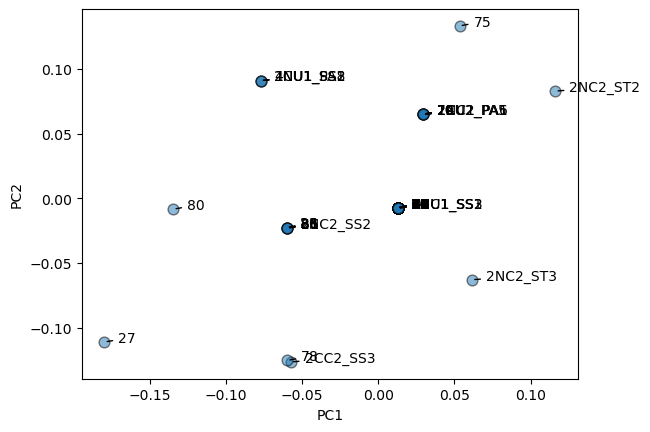

In [126]:
import matplotlib.pyplot as plt
from random import randint
from collections import defaultdict
%matplotlib inline

#labels = list(dm.columns)
x = new_coords[:,0]
y = new_coords[:,1]
fig,ax = plt.subplots()
ax.scatter(x, y,alpha=0.5,edgecolor="black",s=60)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

sample_ids = list(distance_matrix.columns)

xy_labels = defaultdict(list)
for i, txt in enumerate(sample_ids):
    
    xy_count[(x[i],y[i])] +=1
    offset = 10
    text_x = x[i]
    text_y = y[i]
    ax.annotate(txt, xy= (x[i], y[i]),xytext= (text_x+offset,text_y),textcoords='offset points',
            arrowprops=dict(arrowstyle='-'))

Our samples are now showing up in the ordination, but many perfectly overlap, making it hard to read the labels.
There are several potential solutions, but for now let's replace overlapping labels with a single label that lists all the points at that set of coordinates.

We can do this by looping over the x,y coordinates, and adding all labels at that coordinate to a dictionary. When we then annotate the plot with the contents of the dictionary, we will get lists of annotations for each coordinate.

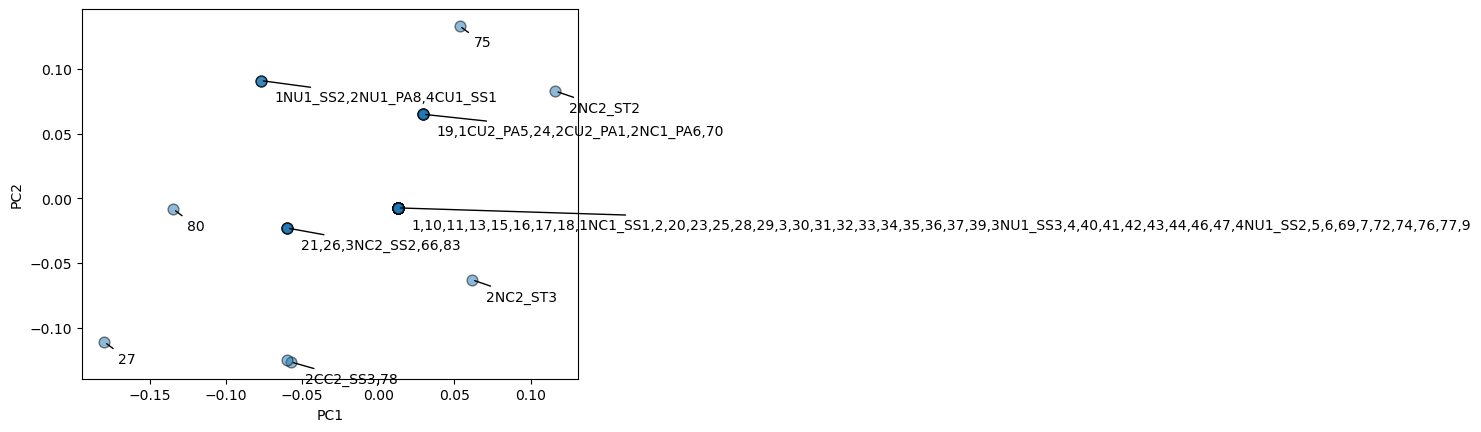

In [127]:
import matplotlib.pyplot as plt
from random import randint
from collections import defaultdict
%matplotlib inline

#labels = list(dm.columns)
x = new_coords[:,0]
y = new_coords[:,1]
fig,ax = plt.subplots()
ax.scatter(x, y,alpha=0.5,edgecolor="black",s=60)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

sample_ids = list(distance_matrix.columns)

xy_labels = defaultdict(list)

#How close of points do we want to collapse?
#Set a label precision variable to control
#how many digits we round to when collapsing 
#labels for samples into a single label
label_precision = 2

#Find overlapping clusters of points,
#using rounding 
for i, sample_id in enumerate(sample_ids): 
    approx_x = round(x[i],label_precision)
    approx_y = round(y[i],label_precision)
    xy_labels[(approx_x,approx_y)].append(sample_id)

#Only annotate clusters we haven't yet marked
already_annotated = []
for i, sample_id in enumerate(sample_ids):
    approx_x = round(x[i],label_precision)
    approx_y = round(y[i],label_precision)
    x_offset = 10
    y_offset = -15
    text_x = approx_x+x_offset
    text_y = approx_y+y_offset
    txt = ",".join(xy_labels[(approx_x,approx_y)])
    if (approx_x,approx_y) not in already_annotated:
        ax.annotate(txt, xy= (x[i], y[i]),xytext= (text_x,text_y),textcoords='offset points',ha="left",
                arrowprops=dict(arrowstyle='-'))
        already_annotated.append((approx_x,approx_y))
        

These PCoA or MDS ordination plots aren't very interesting on their own. Instead, data are usually colored by categorical or quantitiative metadata contained in a separate file. For example, in the microbiome data shown above, each sample is an individual coral that was in a plot with or without added nutrients, and with or without
a cage that kept out herbivorous fish. 


In [128]:
metadata =  pd.read_csv("individual_mapping_r3.txt",sep="\t")
metadata = metadata.set_index('#SampleID')
metadata

,plot,Caged,Nutrients,Coral,Genus,Species,initial_diameter_cm,tissue_change_score,tissue_change_percent,dead_by_end,...,Dictytoa,Amphiroa,Sargassum,Halimeda,Turf,Sediment,Cyanobacteria,Algae,AlgaeAndSediment,Bleached
#SampleID,,,,,,,,,,,,,,,,,,,,,
1,1,1,0,PA1,Porites,P porites,7,-2,-18,No,...,Yes,No,No,Yes,Yes,No,No,Yes,No,No
2,1,0,0,AG1,Agaricia,A agaricites,7,0,0,No,...,No,No,No,No,No,No,No,No,No,No
3,1,1,0,AG1,Agaricia,A humilis,1.5,4,62,No,...,Yes,No,No,No,No,No,No,Yes,No,No
4,1,1,0,PA1,Porites,P porites,5,-5,-87,No,...,No,No,No,No,Yes,Yes,No,Yes,Yes,No
5,1,0,0,PA2,Porites,P porites,4.5,2,18,No,...,No,No,No,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4NU1_PA2,4,0,1,PA2,Porites,P porites,2,-6,-100,Yes,...,Yes,No,No,No,No,No,No,Yes,No,No
4NU1_SS2,4,0,1,SS2,Siderastrea,S siderea,2,2,18,No,...,No,No,No,No,No,No,No,No,No,No
4NU2_DC1,4,0,1,DC1,Dichocoenia,Dichocoenia,15,1,5,No,...,No,No,No,No,No,No,No,No,No,No


['plot', 'Caged', 'Nutrients', 'Coral', 'Genus', 'Species', 'initial_diameter_cm', 'tissue_change_score', 'tissue_change_percent', 'dead_by_end', 'pfish_bites', 'binary_tissue_loss', 'tissue_loss', 'DSS', 'Dictytoa', 'Amphiroa', 'Sargassum', 'Halimeda', 'Turf', 'Sediment', 'Cyanobacteria', 'Algae', 'AlgaeAndSediment', 'Bleached']
['pink', 'pink', 'pink', 'pink', 'orange', 'orange', 'orange', 'orange', 'pink', 'pink', 'orange', 'gray', 'pink', 'gray', 'pink', 'pink', 'pink', 'orange', 'orange', 'orange', 'orange', 'orange', 'pink', 'pink', 'orange', 'orange', 'orange', 'orange', 'pink', 'orange', 'orange', 'pink', 'pink', 'pink', 'pink', 'pink', 'pink', 'pink', 'orange', 'orange', 'pink', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'pink', 'orange', 'pink', 'orange', 'pink', 'orange', 'orange', 'orange', 'orange', 'pink', 'gray', 'pink', 'orange', 'orange', 'orange', 'gray', 'orange']


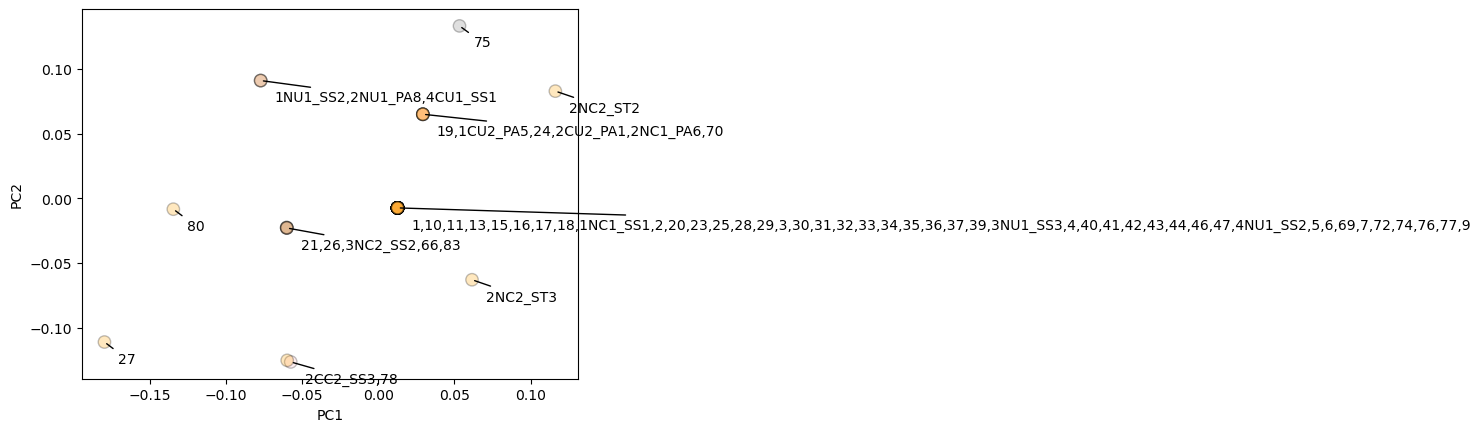

In [136]:
print(list(metadata.columns))

color_col = "Nutrients"
colors = {0:"pink", 1:"orange","other":"gray"}

color_list = []
for s in sample_ids:
    try:
        s_category = metadata.loc[s,"Nutrients"]
        s_color = colors[s_category]
    except:
        s_color = colors["other"]
    color_list.append(s_color)
print(color_list)

##Repeat scatterplot code as before but specify color list

import matplotlib.pyplot as plt
from random import randint
from collections import defaultdict
%matplotlib inline

#labels = list(dm.columns)
x = new_coords[:,0]
y = new_coords[:,1]
fig,ax = plt.subplots()
ax.scatter(x, y,alpha=0.25,edgecolor="black",s=80,c=color_list)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

sample_ids = list(distance_matrix.columns)

xy_labels = defaultdict(list)

#How close of points do we want to collapse?
#Set a label precision variable to control
#how many digits we round to when collapsing 
#labels for samples into a single label
label_precision = 2

#Find overlapping clusters of points,
#using rounding 
for i, sample_id in enumerate(sample_ids): 
    approx_x = round(x[i],label_precision)
    approx_y = round(y[i],label_precision)
    xy_labels[(approx_x,approx_y)].append(sample_id)

#Only annotate clusters we haven't yet marked
already_annotated = []
for i, sample_id in enumerate(sample_ids):
    approx_x = round(x[i],label_precision)
    approx_y = round(y[i],label_precision)
    x_offset = 10
    y_offset = -15
    text_x = approx_x+x_offset
    text_y = approx_y+y_offset
    txt = ",".join(xy_labels[(approx_x,approx_y)])
    if (approx_x,approx_y) not in already_annotated:
        ax.annotate(txt, xy= (x[i], y[i]),xytext= (text_x,text_y),textcoords='offset points',ha="left",
                arrowprops=dict(arrowstyle='-'))
        already_annotated.append((approx_x,approx_y))
        

## Exercises

- Jaccard distances collapse ecological data to presence/absence. This results in many 'identical' samples if the same species are present. What do you think would happen if our beta diversity metric were replaced with one that accounted for abundance?

- Pick a quantitative beta-diversity metric, research it, and implement it as a function in python. Examples include Euclidean distance or Bray-Curtis dissimilarity. Test your metric using a set of distances.

- Rerun the beta-diversity analysis up above using your metric. How did the visualization change?

## Reading Responses & Feedback 

^Make this a hyperlink using Google Forms

## Further Reading

## References